In [1]:
%matplotlib inline

In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [3]:
from types import SimpleNamespace

import scipy.constants

###################################################################
# Units
# Length : nm
# Energy : meV
# Current : nA
# Temperature : K

constants = SimpleNamespace(
    hbar=scipy.constants.hbar,
    m_e=scipy.constants.m_e,
    eV=scipy.constants.eV,
    e=scipy.constants.e,
    meV=scipy.constants.eV * 1e-3,
    k_B=scipy.constants.k / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants["Bohr magneton"][0]
    / (scipy.constants.eV * 1e-3),
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,
)

In [4]:
plt.style.use("../../sans_style.mplstyle")
plt.close("all")


pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)
line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]

In [5]:
simname = "Fig6"

a_label = r"$\theta_C$"
b_label = r"$h_C / \Delta$"

Delta_0 = 0.250

a_scale = 1
b_scale = Delta_0

In [6]:
ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [7]:
b_ax

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875,
       0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875,
       0.5   , 0.5125, 0.525 , 0.5375, 0.55  , 0.5625, 0.575 , 0.5875,
       0.6   , 0.6125, 0.625 , 0.6375, 0.65  , 0.6625, 0.675 , 0.6875,
       0.7   , 0.7125, 0.725 , 0.7375, 0.75  , 0.7625, 0.775 , 0.7875,
       0.8   , 0.8125, 0.825 , 0.8375, 0.85  , 0.8625, 0.875 , 0.8875,
       0.9   , 0.9125, 0.925 , 0.9375, 0.95  , 0.9625, 0.975 , 0.9875,
       1.    , 1.0125, 1.025 , 1.0375, 1.05  , 1.0625, 1.075 , 1.0875,
       1.1   , 1.1125, 1.125 , 1.1375, 1.15  , 1.1625, 1.175 , 1.1875,
       1.2   , 1.2125, 1.225 , 1.2375, 1.25  ])

In [8]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 100 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [9]:
# Set the temperature
T = 20e-3  # mK

f = -(constants.k_B * T) * logcosh(ws / (2 * constants.k_B * T))
F = np.sum(f, axis=-1)

F.name = "F"

In [10]:
# arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

# mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
# vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

# for n in range(len(arm[0])):
#     i = arm[0][n]
#     j = arm[1][n]
#     n = arm[2][n]

#     mins_list[i][j].append(theta_ax[n])
#     vmins_list[i][j].append(F[i, j, n])

In [11]:
# pd = np.zeros((a_N, b_N)) * np.nan
# pdm = np.zeros((a_N, b_N)) * np.nan
# pdf = np.zeros((a_N, b_N)) * np.nan

# for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

#     if len(mins_list[i][j]) == 1:
#         if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
#             pd[i][j] = 0
#         else:
#             pd[i][j] = 3.14

#     elif len(mins_list[i][j]) == 2:
#         vmmin = np.argmin(vmins_list[i][j])
#         mmin = mins_list[i][j][vmmin]

#         if abs(mmin) < abs(mmin - np.pi):
#             pd[i][j] = 3.14 / 3
#         else:
#             pd[i][j] = 2 * 3.14 / 3

#     else:
#         pd[i][j] = np.mean(mins_list[i][j])
#     pdm[i][j] = np.mean(mins_list[i][j])
#     pdf[i][j] = mins_list[i][j][0]

In [12]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

eta = (abs(I.max("theta")) - abs(I.min("theta"))) / (
    abs(I.max("theta")) + abs(I.min("theta"))
).to_numpy()

I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

In [13]:
N = F.shape[-1]

ks = rfftfreq(N, 1 / N)
F_k = 2.0 / N * rfft(F)
cF_k = +F_k.real
sF_k = -F_k.imag

In [14]:
diffabs = abs(cF_k[..., 2]) - abs(cF_k[..., 1])

In [15]:
I = I.to_numpy().astype(float) + 1e-6

In [16]:
coords_1 = [28, 75]

ws_red = ws[coords_1[0], coords_1[1]]


# Set the temperature
T_N = 101
T_ax = np.linspace(1e-3, 500e-3, T_N)  # mK

F_red = np.zeros((T_N, theta_N))

for i in range(T_N):
    f = -(constants.k_B * T_ax[i]) * logcosh(ws_red / (2 * constants.k_B * T_ax[i]))
    F_red[i] = np.sum(f, axis=-1)

I_red = (np.roll(F_red, -1, axis=-1) - F_red) / dtheta
I_red *= 2 * constants.e / constants.hbar * constants.meV * 1e9

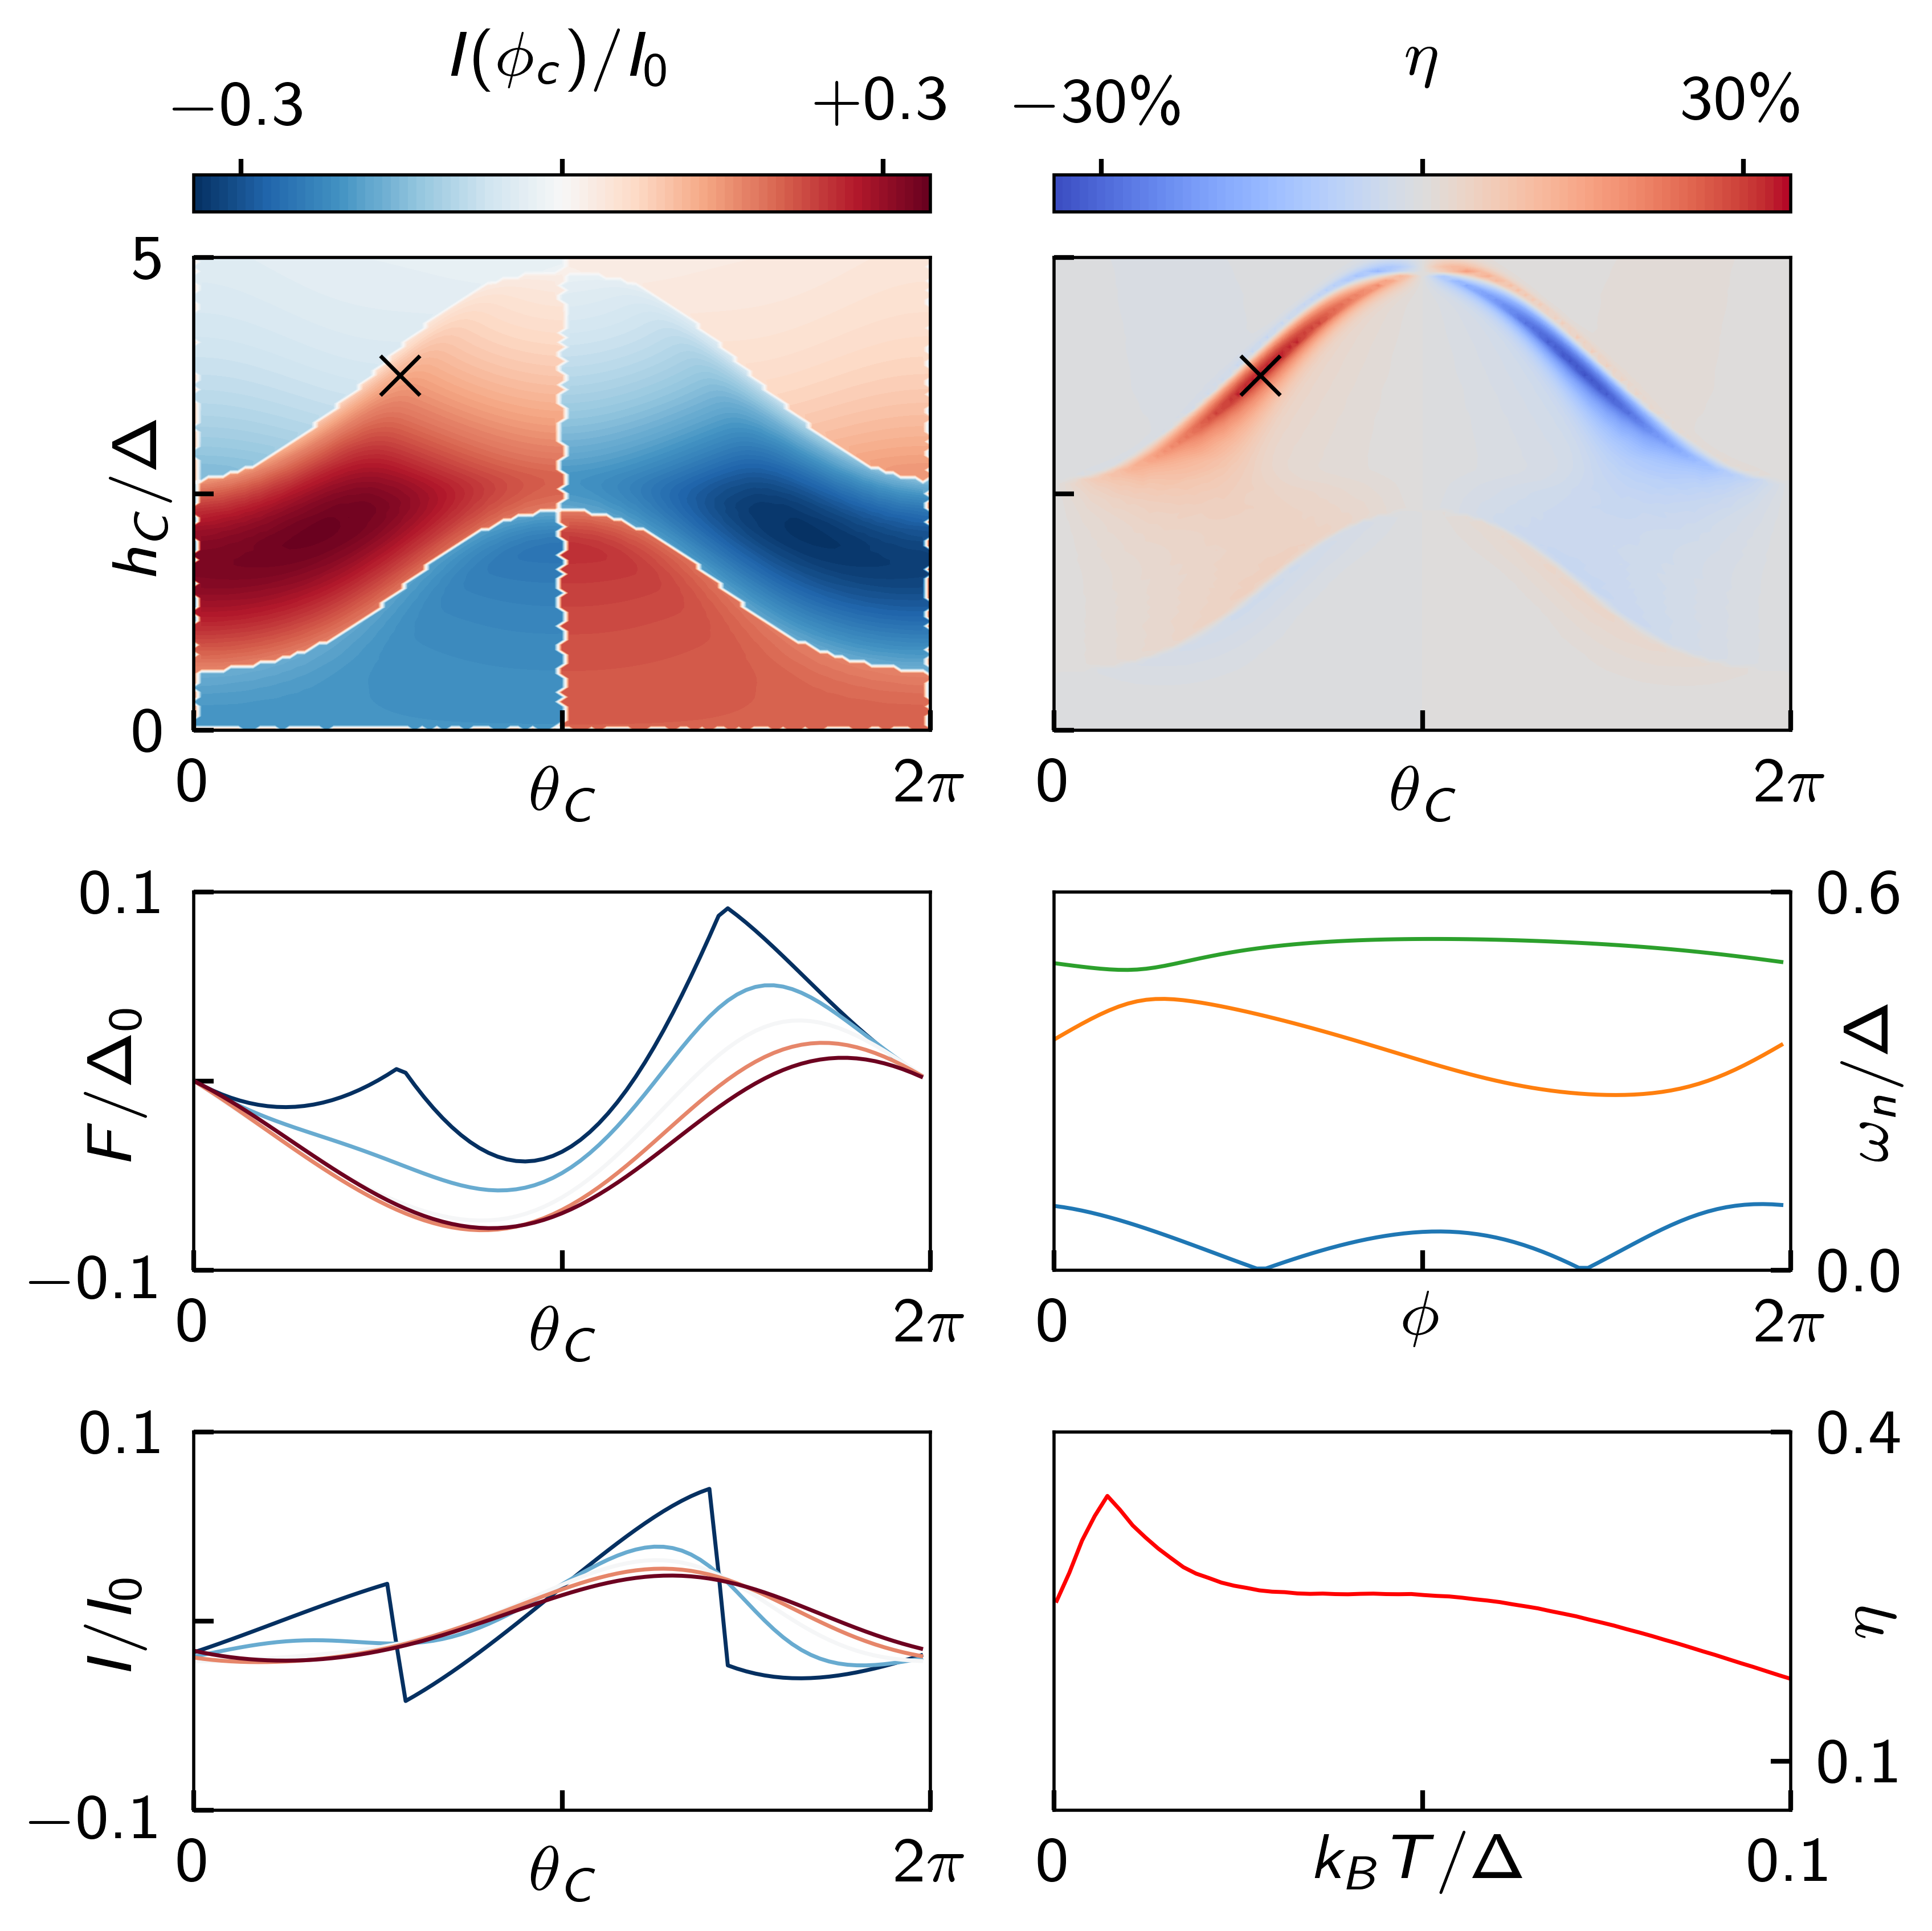

In [17]:
fig = plt.figure(dpi=1000, figsize=(3.375, 3.375), layout="constrained")
spec = fig.add_gridspec(3, 2, height_ratios=[1.25, 1, 1])

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)

##############################################################

im1 = ax1.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=101,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)

ax1.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color="k",
    marker="x",
)

ax1.set_xticks([0, np.pi, 2 * np.pi], labels=["$0$", "", "$2\pi$"])
ax1.set_xlabel(a_label, labelpad=-6)
ax1.set_xlim(0, 2 * np.pi)

ax1.set_yticks([0, 2.5, 5], labels=[r"$0$", r"", r"$5$"])
ax1.set_ylabel(b_label, labelpad=-5)

##############################################################

im2 = ax2.contourf(
    a / a_scale,
    b / b_scale,
    eta,
    levels=101,
    norm=mpl.colors.CenteredNorm(),
    cmap="coolwarm",
    zorder=-30,
)

ax2.scatter(
    a_ax[coords_1[0]] / a_scale,
    b_ax[coords_1[1]] / b_scale,
    color="k",
    marker="x",
)

ax2.set_xticks([0, np.pi, 2 * np.pi], labels=["$0$", "", "$2\pi$"])
ax2.set_xlabel(a_label, labelpad=-6)
ax2.set_xlim(0, 2 * np.pi)

ax2.set_yticks([0, 2.5, 5], labels=[])

##############################################################


for i in range(0, T_N, 25):
    ax3.plot(
        theta_ax,
        (F_red[i] - F_red[i, 0]) / Delta_0,
        "-",
        color=mpl.colormaps.get("RdBu_r")(i / T_N),
    )

ax3.set_xticks([0, np.pi, 2 * np.pi], labels=["$0$", "", "$2\pi$"])
ax3.set_xlabel(a_label, labelpad=-6)
ax3.set_xlim(0, 2 * np.pi)

ax3.set_ylim(-0.1, 0.1)
ax3.set_yticks(np.array([-0.1, 0, 0.1]), labels=[r"$-0.1$", r"", r"$0.1$"])
ax3.set_ylabel(r"$F/\Delta_0$", labelpad=-15)
# ax3.yaxis.set_label_position("right")
# ax3.yaxis.tick_right()

###########################################
# ax4.fill_between(
#     x=theta_ax,
#     y1=I[coords_1[0], coords_1[1]] / I_0,
#     y2=0,
#     color=line_colors[0],
#     alpha=0.2,
#     linewidth=0,
# )

# ax4.plot(
#     theta_ax,
#     I[coords_1[0], coords_1[1]] / I_0,
#     "-",
#     color=line_colors[0],
# )

ax4.plot(theta_ax, ws_red / Delta_0, "-", linewidth=0.5)  # , c='C0')

ax4.set_xlim(0, 2 * np.pi)
ax4.set_xticks([0, np.pi, 2 * np.pi], labels=["$0$", "", "$2\pi$"])
ax4.set_xlabel("$\phi$", labelpad=-8)


ax4.set_ylim(0, 0.6)
ax4.set_yticks([0, 0.6])
ax4.set_ylabel(r"$\omega_n / \Delta$", labelpad=-8)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

################################


for i in range(0, T_N, 25):
    ax5.plot(theta_ax, I_red[i] / I_0, "-", color=mpl.colormaps.get("RdBu_r")(i / T_N))

ax5.set_ylim(-0.2, 0.2)
ax5.set_yticks(np.array([-0.2, 0, 0.2]), labels=[r"$-0.1$", r"", r"$0.1$"])
ax5.set_ylabel(r"$I/I_0$", labelpad=-15)
# ax5.yaxis.set_label_position("right")
# ax5.yaxis.tick_right()

# ax5.set_xticks(
#     np.array([0, 0.5, 1, 1.5, 2]) * np.pi, labels=[r"$0$", r"", r"", r"", r"$2\pi$"]
# )
# ax5.set_xlabel(r"$\phi$", labelpad=-5)
# ax5.set_xlim(0, 2 * np.pi)

# ax5.yaxis.set_label_position("right")
# ax5.yaxis.tick_right()
# ax5.set_ylim(-0.45, 0.45)
# ax5.set_ylabel(r"$I/I_0$", labelpad=-15)
# ax5.set_yticks(np.array([-0.4, 0, 0.4]), labels=[r"$-0.4$", r"", r"$0.4$"])

# spec.tight_layout(fig)


ax5.set_xticks([0, np.pi, 2 * np.pi], labels=["$0$", "", "$2\pi$"])
ax5.set_xlabel(a_label, labelpad=-6)
ax5.set_xlim(0, 2 * np.pi)

################################

ax6.plot(
    constants.k_B * T_ax / Delta_0,
    (np.max(I_red, axis=-1) + np.min(I_red, axis=-1))
    / (np.max(I_red, axis=-1) - np.min(I_red, axis=-1)),
    "-",
    c="r",
)
# ax6.plot(constants.k_B * T_ax / Delta_0, np.max(abs(I_red), axis=-1)/ I_0, '-', c='r')

ax6.set_xlabel(r"$k_B T / \Delta$", labelpad=-8)
ax6.set_xlim(0, 0.1)
ax6.set_xticks([0, 0.05, 0.1], labels=[r"$0$", "", r"$0.1$"])

ax6.set_ylabel(r"$\eta$", labelpad=-8)
ax6.set_yticks([0.1, 0.4])
ax6.yaxis.set_label_position("right")
ax6.yaxis.tick_right()

#########################################
cbar1 = fig.colorbar(im1, ax=ax1, format="%3.2f", location="top")
cbar1.set_ticks([-0.3, 0, 0.3], labels=[r"$-0.3$", "", r"$+0.3$"])
# cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=2, direction="out")
cbar1.set_label(r"$I(\phi_c)/I_0$", labelpad=0)

#########################################
cbar2 = fig.colorbar(im2, ax=ax2, format="%3.2f", location="top")
cbar2.set_ticks([-0.3, 0, 0.3], labels=[r"$-30\%$", "", r"$30\%$"])
cbar2.ax.tick_params(length=2, direction="out")
cbar2.set_label(r"$\eta$", labelpad=0)

#########################################
# axins = ax4.inset_axes([0.01, 0.01, 0.5, 0.5])
# axins.set_rasterization_zorder(0)

# im = axins.plot(ws_red.T / Delta_0, c='C0')
# axins.set_ylim(-1, 1)

# axins.hlines([b_ax[b_cut_idx] / b_scale], 0, 1.2, colors="k", linestyles="--")

# axins.set_xticks([0, 0.5, 1])
# axins.set_xticklabels([])

# axins.set_yticks([5, 10, 15], labels=[])

###################################
# cb_axins = ax2.inset_axes([0.01, 0.52, 0.5, 0.02])
# cbar2 = fig.colorbar(im, cax=cb_axins, orientation="horizontal")
# cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
# cbar2.ax.xaxis.set_label_position("top")
# cbar2.ax.xaxis.tick_top()
# cbar2.ax.tick_params(length=2, direction="out")
# cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-5)

# cb_axins = ax4.inset_axes([-0.03, 0.01, 0.02, 0.5])
# cbar2 = fig.colorbar(im, cax=cb_axins)

# cbar2.set_ticks([-0.3, 0, 0.7], labels=[r"$-0.3$", "", r"$0.7$"])
# cbar2.ax.yaxis.set_label_position("left")
# cbar2.ax.yaxis.tick_left()
# cbar2.ax.tick_params(length=2, direction="out")
# cbar2.set_label(r"$I_\mathrm{c} / I_0$", labelpad=-15)

fig.savefig("Fig6-non_reciprocal.svg")

In [44]:
def add_label(ax, text, position="tl", color=[1, 1, 1, 0.90]):
    if position=="tl":
        ax.text(
            0.03,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position=='tr':
        ax.text(
            0.65,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position=='bl':
        ax.text(
            0.03,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position=='br':
        ax.text(
            0.65,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    else:
        pass

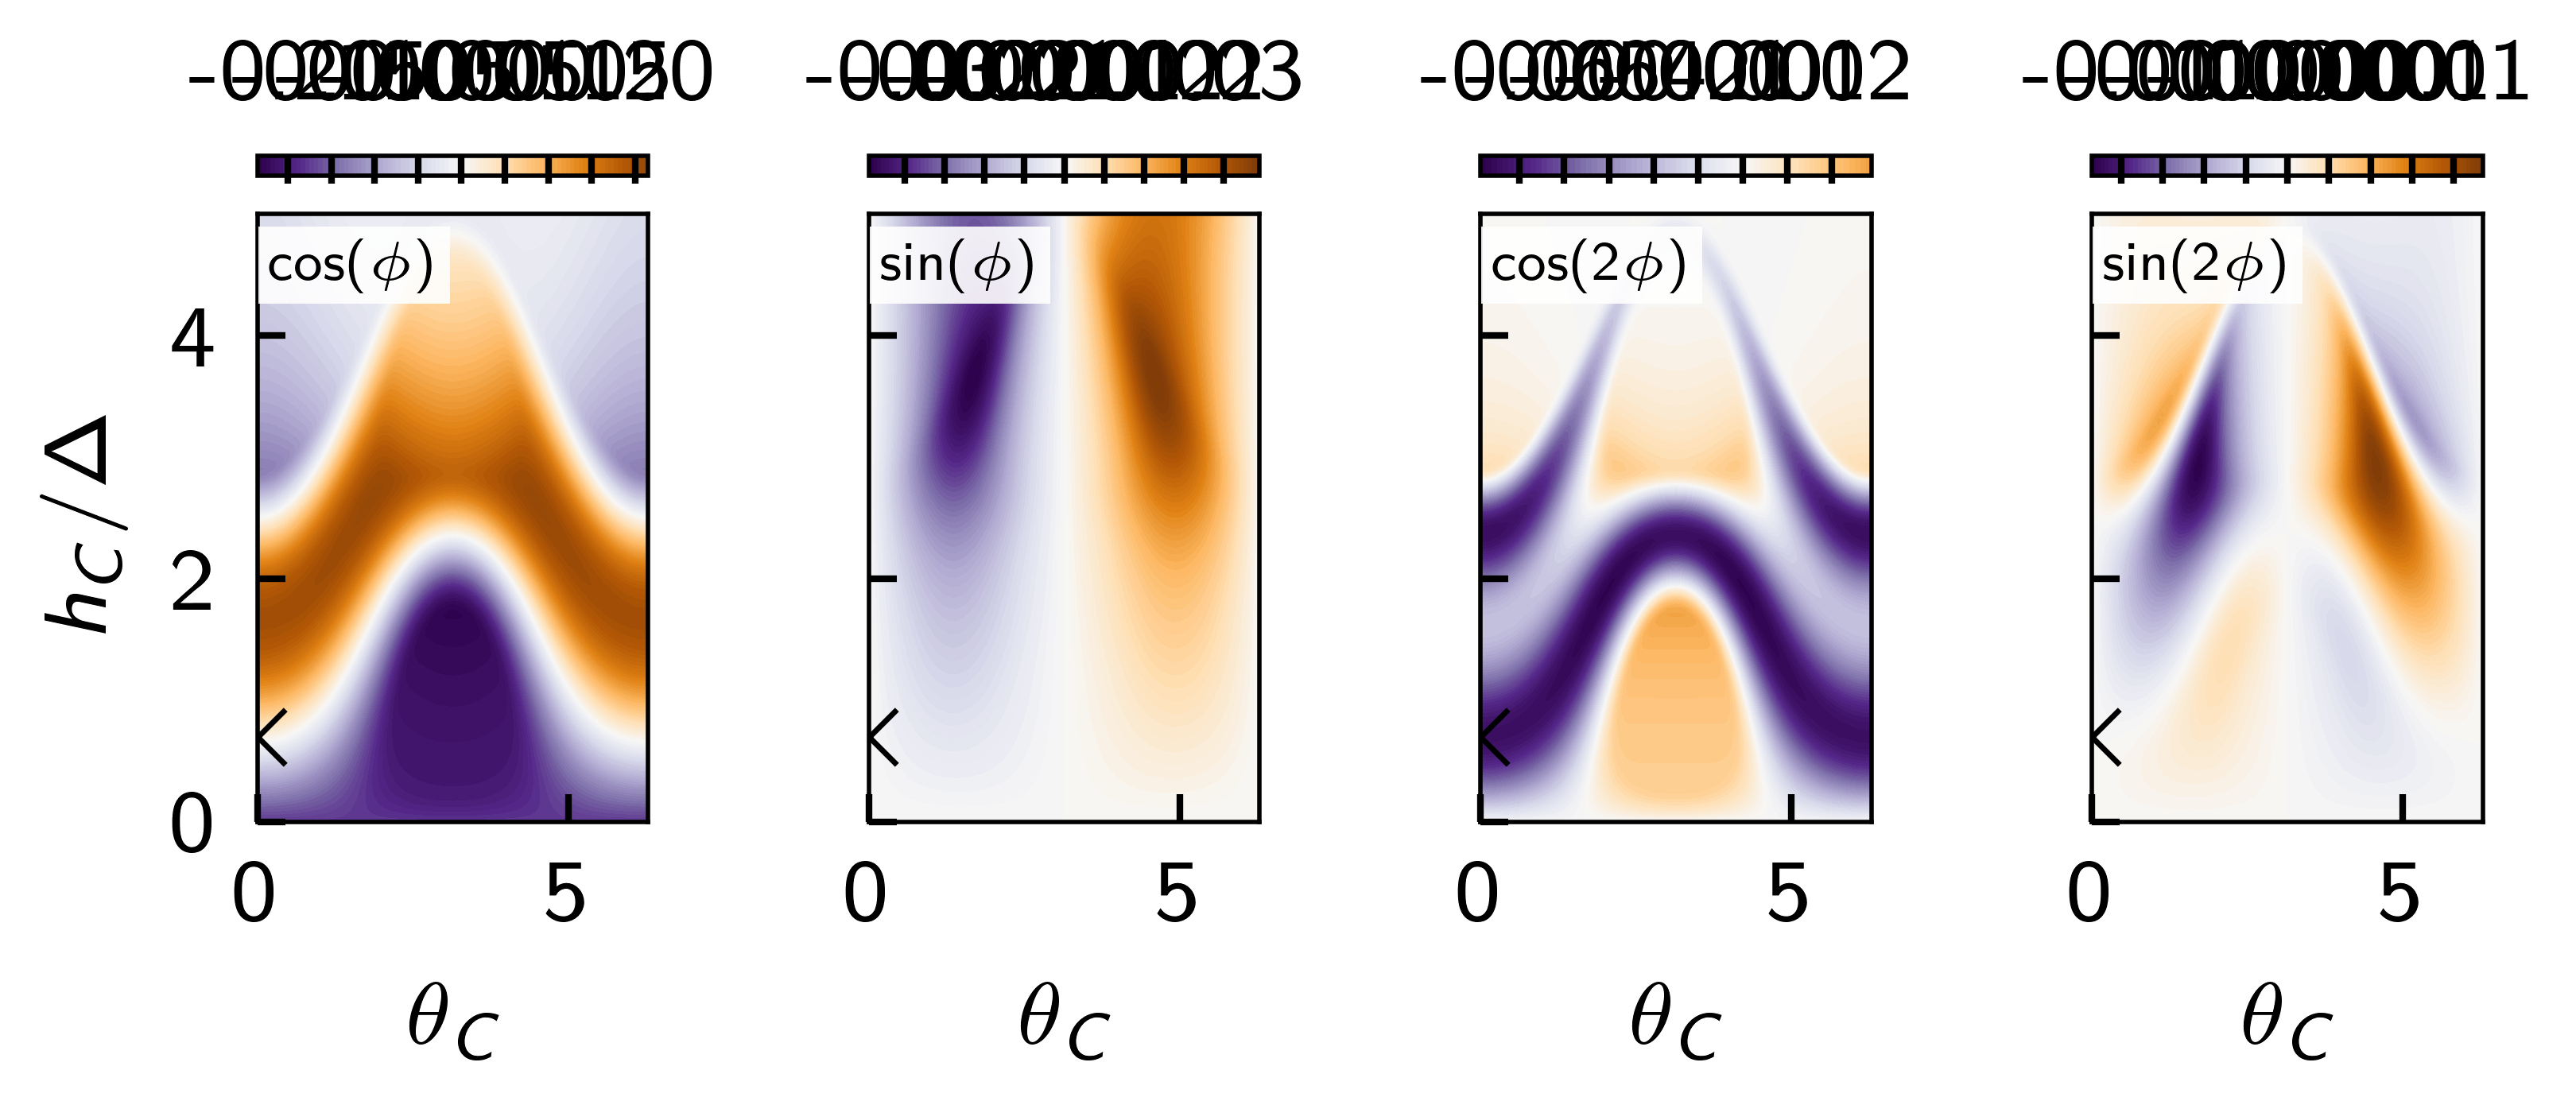

In [51]:
what1 = cF_k[..., 1] / Delta_0
what2 = sF_k[..., 1] / Delta_0
what3 = cF_k[..., 2] / Delta_0
what4 = sF_k[..., 2] / Delta_0
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(ncols=4, nrows=1, figsize=(3.375, 1.5), sharex=True, sharey=True)

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
ax4.set_rasterization_zorder(0)

ax1.set_xlabel(a_label)
ax1.set_ylabel(b_label)

ax2.set_xlabel(a_label)
#ax2.set_ylabel(b_label)

ax3.set_xlabel(a_label)
#ax3.set_ylabel(b_label)

ax4.set_xlabel(a_label)
#ax4.set_ylabel(b_label)

im1 = ax1.contourf(
    a / a_scale,
    b / b_scale,
    what1,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im1, ax=ax1, format="%3.2f", location='top')
add_label(ax1, r"$\cos(\phi)$", "tl")

im2 = ax2.contourf(
    a / a_scale,
    b / b_scale,
    what2,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im2, ax=ax2, format="%3.2f", location='top')
add_label(ax2, r"$\sin(\phi)$", "tl")

im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    what3,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im3, ax=ax3, format="%3.2f", location='top')
add_label(ax3, r"$\cos(2\phi)$", "tl")


im4 = ax4.contourf(
    a / a_scale,
    b / b_scale,
    what4,
    levels=100,
    cmap="PuOr_r",
    zorder=-30,
    norm=mpl.colors.CenteredNorm(0),
)
fig.colorbar(im4, ax=ax4, format="%3.2f", location='top')
add_label(ax4, r"$\sin(2\phi)$", "tl")

# ax3.scatter(coords[:, 0], coords[:, 1], c=colors, zorder=10, marker="x")

ax1.scatter(0, 0.7, c="k", marker="x")
ax2.scatter(0, 0.7, c="k", marker="x")
ax3.scatter(0, 0.7, c="k", marker="x")
ax4.scatter(0, 0.7, c="k", marker="x")

fig.tight_layout()
# fig.savefig(f"./output/{simname}/plots/{simname}_harmonics.svg")

(0.0, 1.0)

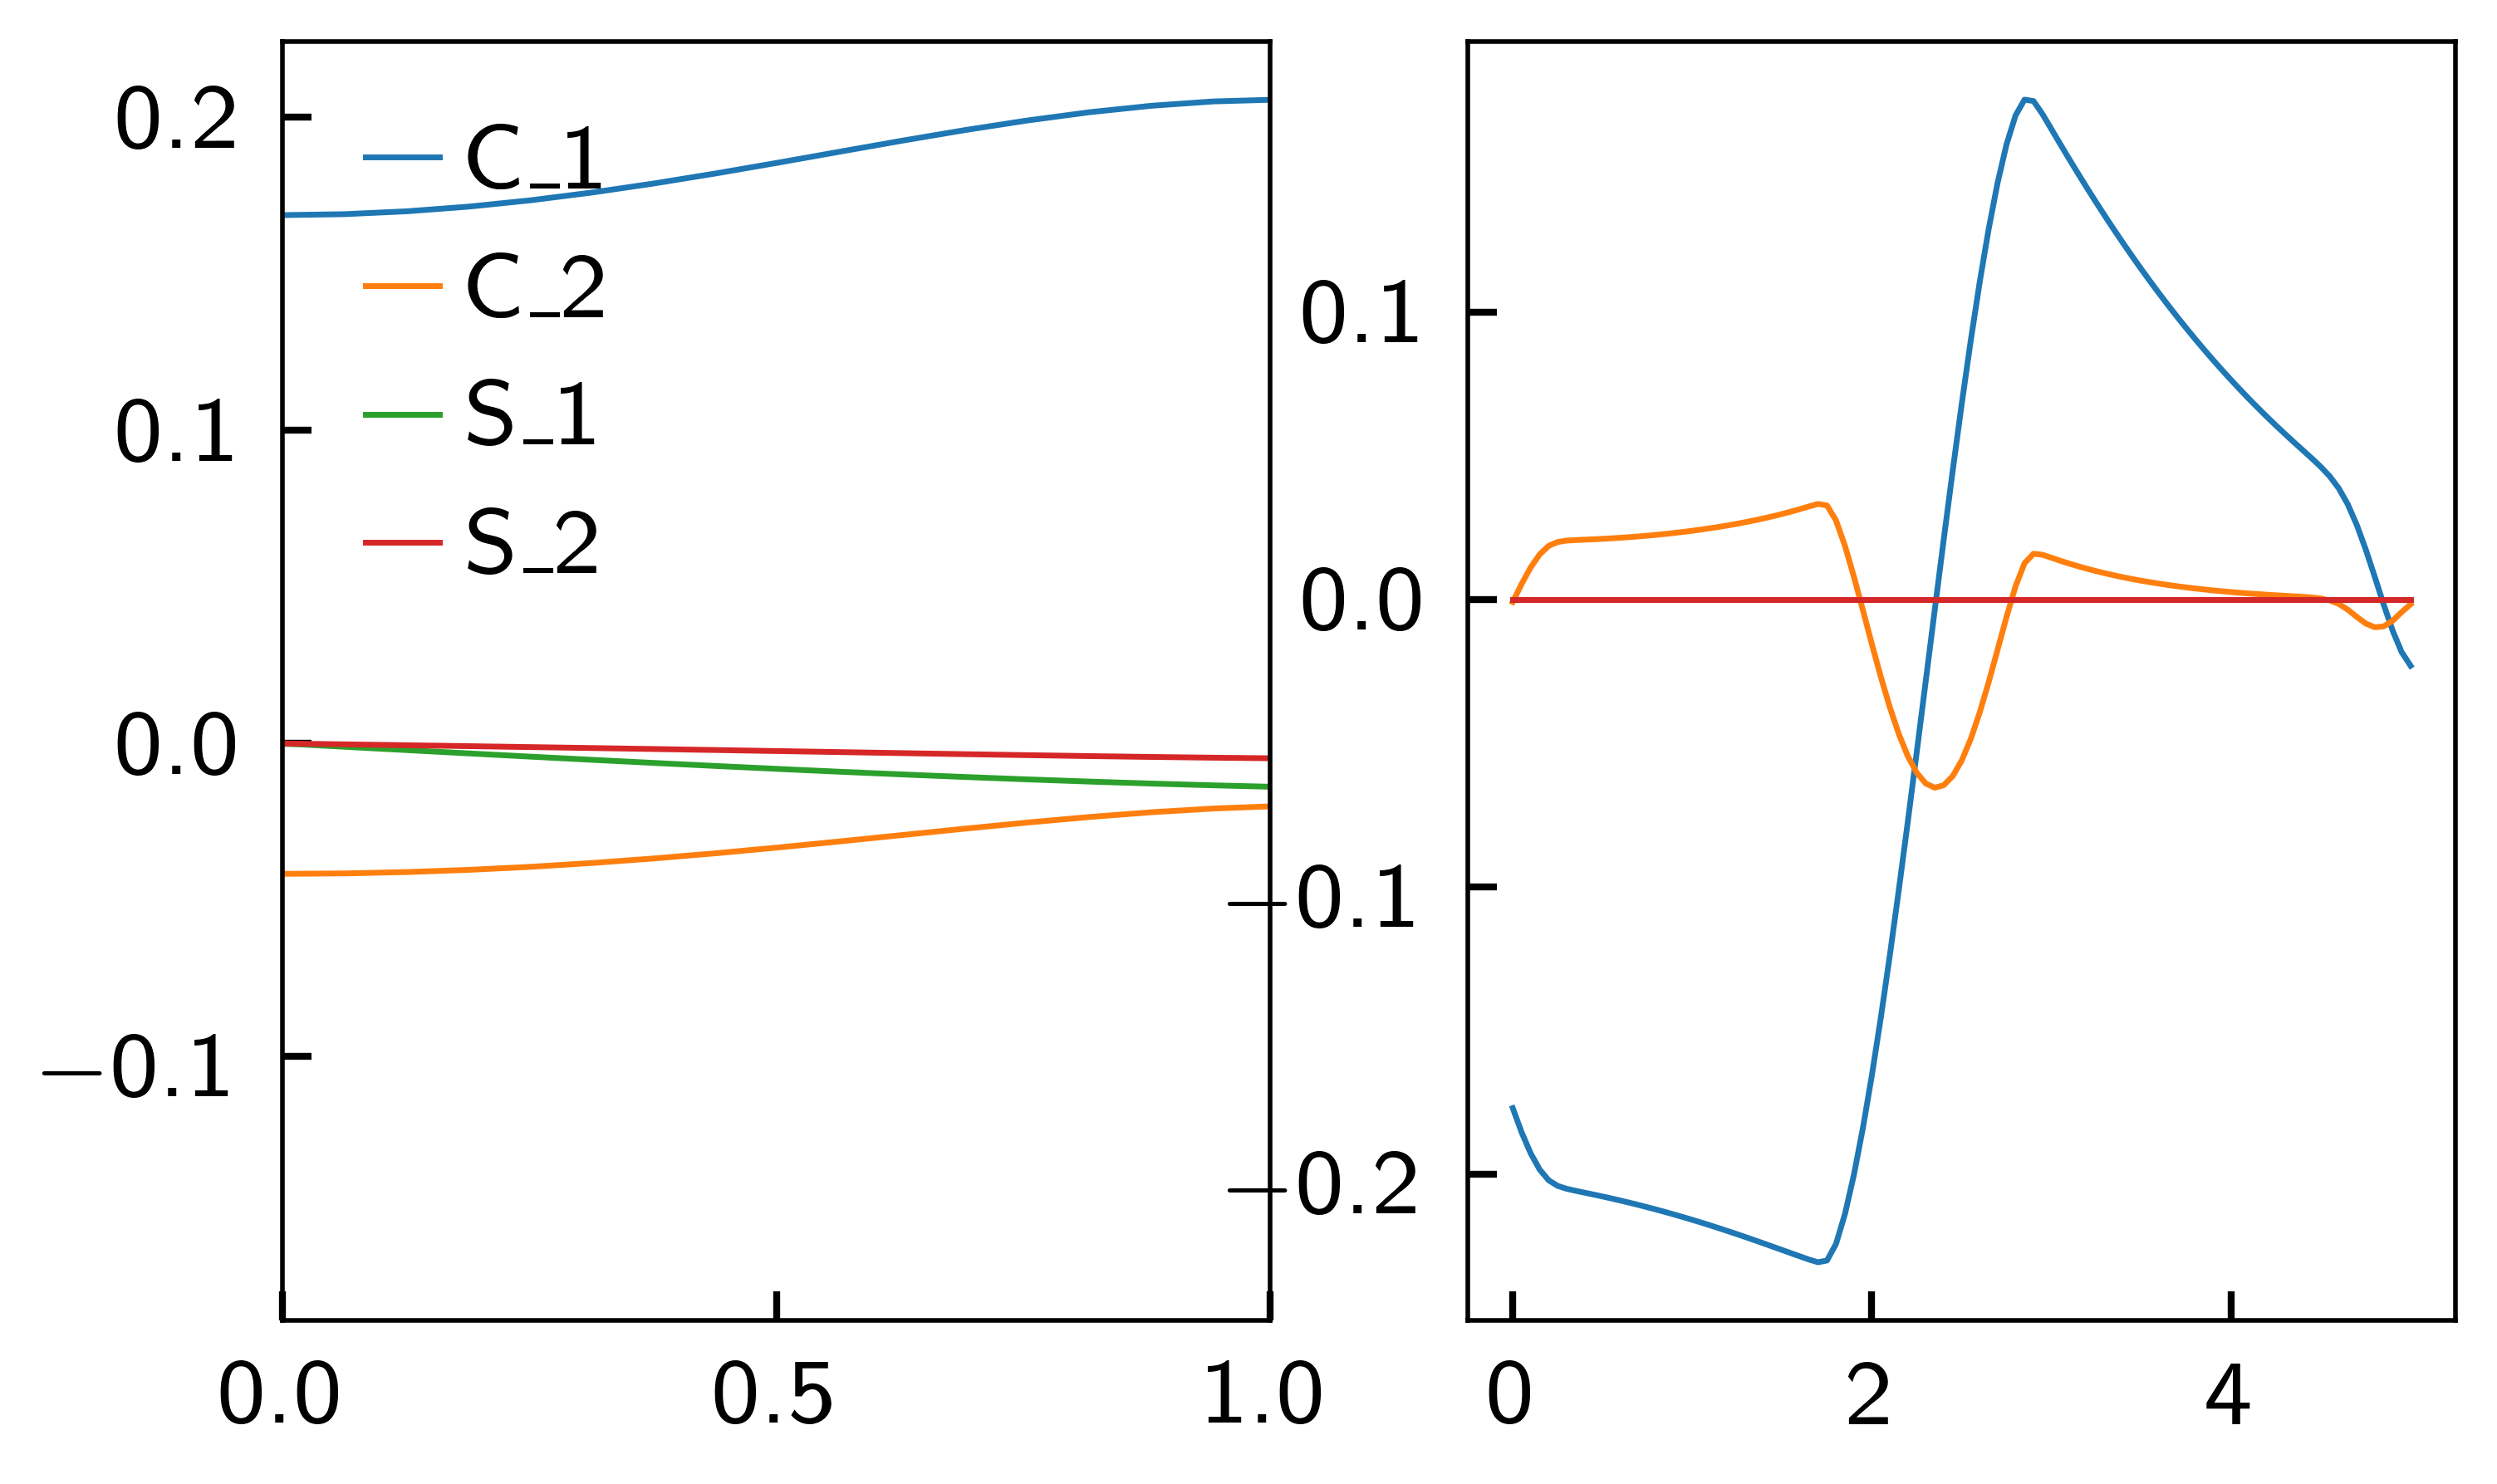

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2)


#a_coord = np.argmin(abs(a_ax / a_scale - 0))
#b_coord = np.argmin(abs(b_ax / b_scale - 0.65))

a_coord = np.argmin(abs(a_ax / a_scale - np.pi))
b_coord = np.argmin(abs(b_ax / b_scale - 2.0))

ax1.plot(a_ax / a_scale, cF_k[:, b_coord, 1] / Delta_0, "-", label="C_1")
ax1.plot(a_ax / a_scale, cF_k[:, b_coord, 2] / Delta_0, "-", label="C_2")
ax1.plot(a_ax / a_scale, sF_k[:, b_coord, 1] / Delta_0, "-", label="S_1")
ax1.plot(a_ax / a_scale, sF_k[:, b_coord, 2] / Delta_0, "-", label="S_2")

ax2.plot(b_ax / b_scale, cF_k[a_coord, :, 1] / Delta_0, "-", label="C_1")
ax2.plot(b_ax / b_scale, cF_k[a_coord, :, 2] / Delta_0, "-", label="C_2")
ax2.plot(b_ax / b_scale, sF_k[a_coord, :, 1] / Delta_0, "-", label="S_1")
ax2.plot(b_ax / b_scale, sF_k[a_coord, :, 2] / Delta_0, "-", label="S_2")

ax1.legend()

ax1.set_xlim(0, 1)